In [346]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import sparse as ssp
import scipy.linalg as salg
from scipy.sparse.linalg import spsolve, splu
from collections.abc import Callable


In [347]:
#Defining the constants
P = 2		#Power of two
N = 2**P	#Number of subdivisions
U0 = 0.01 	#The border constant we might need to use?
h = 1/N		#Discretisation step

DEBUG = True

In [348]:

def get_elem_mat(N: int, dimension: str) -> ssp.csr_matrix:
	"""Creates the element matrix 'Ah' for the 2D or 3D discrete laplaciaan

	Parameters
	----------
	N : int
	    Number of points in a direction of the grid
	dimension : str
	    2D/3D for two/three-dimensional discrete laplacian

	Returns
	-------
	ssp.csc_matrix
	    The element matrix Ah
	"""	
	one_dim_diff = 2*np.eye((N))-np.eye((N), k=-1)-np.eye((N), k=1)


	ONE_DIM_DIFF	= ssp.csr_matrix(one_dim_diff.astype(int))
	ID 		= ssp.csr_matrix(np.eye(N).astype(int))

	x_dim_diff = (1/(h**2) * ssp.kron(ONE_DIM_DIFF,ID))
	y_dim_diff = (1/(h**2) * ssp.kron(ID, ONE_DIM_DIFF))

	X_DIM_DIFF 	= ssp.csr_matrix(x_dim_diff.astype(int))
	Y_DIM_DIFF 	= ssp.csr_matrix(y_dim_diff.astype(int))
	TWO_LAPLACE 	= ssp.csr_matrix(x_dim_diff + y_dim_diff)

	one_dim_diff = None
	x_dim_diff = None
	y_dim_diff = None

	if dimension == "2D":
		return TWO_LAPLACE

	elif dimension == "3D":	
		z_dim_diff = (1/(h**2)*(
			ssp.kron(ID,
				ssp.kron(ID, ONE_DIM_DIFF)
				)
			)
		)

		Z_DIM_DIFF 	= ssp.csr_matrix(z_dim_diff.astype(int))
		z_dim_diff = None

		THREE_LAPLACE = (ssp.kron(X_DIM_DIFF, ID) 
				+ssp.kron(Y_DIM_DIFF, ID)
				+Z_DIM_DIFF)
		
		return THREE_LAPLACE

	else:
		raise ValueError('string: Dimension, either "2D" or "3D"')


In [349]:
def build_forcing_vector(lin_spaces: list,
			 internal_fun,
			 boundary_fun  = None
			 ) -> np.ndarray:
	"""Builds the RHS of the linear system for a arbitray-dimensional laplacian

	Parameters
	----------
	lin_spaces : list
	    List of arrays of points that will be used to build the meshgrid
	internal_fun : Callable[list[float]]
	    Function that takes n-dimensional coordinate arrays and returns the value of the forcing at that coordinate
	boundary_fun : Callable[list[float]]
	    Function that takes n-dimensional coordinate arrays and returns the value of the forcing at that boundary coordinate

	Returns
	-------
	np.ndarray
	    The forcing vector
	"""	
	grids = np.meshgrid(*lin_spaces)
	internal_forcing_array = internal_fun(*grids)
	if boundary_fun == None:
		def boundary_fun(*grids):
			return 0*grids[0]
			
	boundary_forcing_array = boundary_fun(*grids)

	dims = len(lin_spaces)
	mask = tuple([slice(1,-1)]*dims)
	forcing, forcing[mask] = boundary_forcing_array, internal_forcing_array[mask]
	print(mask)

	forcing_vector = forcing.flatten()
	return forcing_vector


In [350]:
def int_forc_fun(x,y):
	return (x**2 + y**2)*np.sin(x*y)

def bound_forc_fun(x,y):
	return np.sin(x*y)

x = np.linspace(0,1,N+1)
y = np.linspace(0,1,N+1)

X, Y = np.meshgrid(x,y)

In [351]:
vecF = build_forcing_vector([x,y], int_forc_fun, bound_forc_fun)

(slice(1, -1, None), slice(1, -1, None))


In [352]:
TWO_LAPLACE = get_elem_mat(N+1, "2D")

In [353]:
#Manipulating the 2D-laplacian and the forcing vector to obey boundary elements
#By selecting the boundary points
Xval, Yval = X.ravel(), Y.ravel()

boundary_list = np.squeeze(
	np.where(
		(Xval==x[0]) | (Xval==x[-1]) | (Yval==y[0]) | (Yval==y[-1])
	)
);

SPARSE_ID = ssp.eye((N+1)**2).tocsr()
for row in boundary_list:
	TWO_LAPLACE[row,:] = SPARSE_ID[row,:]
SPARSE_ID = None



In [354]:

# %time test = TWO_LAPLACE.toarray()
# plt.imshow(test)
# plt.colorbar()

In [355]:
boundary_list

array([ 0,  1,  2,  3,  4,  5,  9, 10, 14, 15, 19, 20, 21, 22, 23, 24],
      dtype=int64)

In [356]:
# test[:,boundary_list] = 0*np.ones(((N+1)**2,(N+1)**2))[:,boundary_list]
# plt.imshow(test)
# plt.colorbar()

In [357]:
size = (N+1)**2

TWO_LAPLACE = TWO_LAPLACE.tocsc()
P_MATRIX = ssp.csc_matrix((size,size))


TWO_LAPLACE.shape


(25, 25)

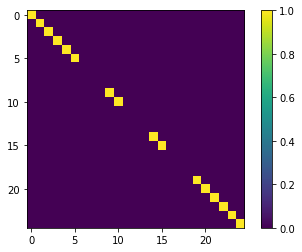

In [358]:
ones = np.zeros((size,size))
ones[boundary_list,boundary_list] = 1

plt.imshow(ones)
plt.colorbar()

In [359]:
ZEROES = ssp.csc_matrix((size,size))

for column in boundary_list:
	P_MATRIX[:, column] = TWO_LAPLACE[:, column]
	TWO_LAPLACE[:,column] = ZEROES[:,column]

print(type(TWO_LAPLACE))

TWO_LAPLACE = (TWO_LAPLACE + ones)
P_MATRIX = (P_MATRIX - ones)

print(type(TWO_LAPLACE))

<class 'scipy.sparse.csc.csc_matrix'>
<class 'numpy.matrix'>


In [360]:
type(P_MATRIX)

numpy.matrix

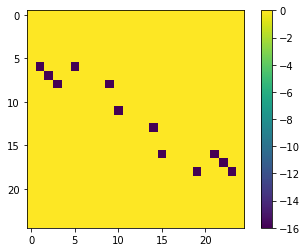

In [361]:
pm = P_MATRIX
plt.imshow(pm)
plt.colorbar()

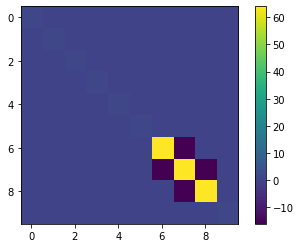

In [362]:
two_lapl = TWO_LAPLACE
plt.imshow(two_lapl[0:10,0:10])
plt.colorbar()

In [363]:
P_MATRIX.shape

(25, 25)

In [364]:
#Building u0
U0 = np.sin(X*Y)
u0 = U0.flatten()
to_subtract = P_MATRIX.dot(u0)


In [365]:
vecF = np.subtract(vecF, to_subtract)

In [366]:
TWO_LAPLACE.shape

(25, 25)

In [367]:
u = spsolve(TWO_LAPLACE, vecF.T)

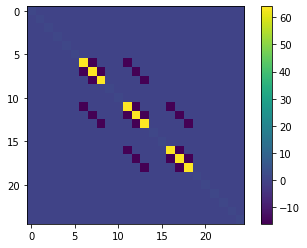

In [368]:
plt.imshow(TWO_LAPLACE)
plt.colorbar()

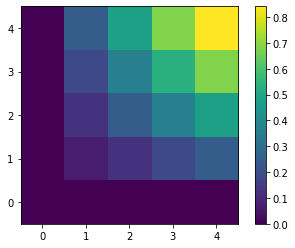

In [369]:
array_u = u.reshape((N+1,N+1))
plt.imshow(array_u, origin='lower');
plt.colorbar()

In [370]:
u_ex = np.sin(X*Y)
vec_u_ex = u_ex.flatten()

In [371]:
error = np.sqrt(h**2 *np.sum((vec_u_ex-u)**2))
print("h**2: {:.5f}\t error: {:.5f}".format(h**2, error))
print('relative error: {:.4f}\t [h**2]'.format(error/(h**2)))

h**2: 0.06250	 error: 0.00002
relative error: 0.0003	 [h**2]


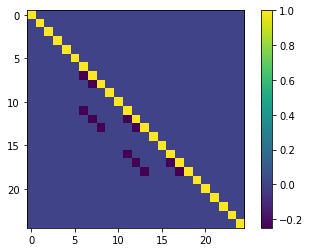

In [405]:
matrix_shape = TWO_LAPLACE.shape
ID = ssp.eye(matrix_shape[0])
zeroes = np.zeros(matrix_shape[0])

SUM = ID.copy()
for k in range(0, matrix_shape[1]):
	Akk = TWO_LAPLACE[k,k]
	vec = np.asarray(TWO_LAPLACE[:,k] / Akk).flatten()
	vec[0:k+1] = zeroes[0:k+1] 

	ek = zeroes.copy()
	ek[k] = 1

	add = np.outer(vec, ek)

	SUM += add

L = SUM

plt.imshow(L)
plt.colorbar()


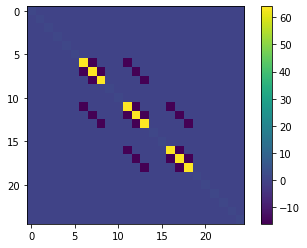

In [408]:
U = salg.solve(L, TWO_LAPLACE)

plt.imshow(L@U)
plt.colorbar()

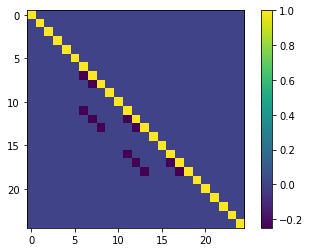

In [397]:
plt.imshow(L)
plt.colorbar()